# Cyber Data Analytics - 2

In [34]:
%matplotlib inline

import pandas as pd
from pandas.plotting import autocorrelation_plot

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix

import statsmodels.tsa.api as smt

from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

import itertools
from collections import defaultdict
import pickle
from datetime import datetime
import os
import sys
from pathlib import Path

def get_relative_attack_data(data_frame, extra):
    """
    Helper function returns the attacks on a time scale of 0 to 1, helper function for plots
    """
    length = len(data_frame['ATT_FLAG'])
    start = 0
    finish = 0
    start_abs = 0
    finish_abs = 0
    block_started = False
    
    absolute_blocks = []
    blocks = []
    for idx, row in enumerate(data_frame['ATT_FLAG']):
        if not block_started and row == 1:
            start = idx / length
            start_abs = idx
            block_started = True
        elif block_started and (row == -999):
            blocks.append((start - extra, ((idx - 1) / length) + extra))
            absolute_blocks.append((start_abs, idx - 1))
            block_started = False
    
    return blocks

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Load data

In [35]:
def parse_date(d):
    return datetime.strptime(d, '%d/%m/%y %H')

data1 = pd.read_csv('training_dataset1.csv', index_col=0, parse_dates=True, squeeze=True, date_parser=parse_date)
data1_period = (data1.head(338)) # 2 weeks period instead of one year
print(data1.shape)
data1.head(5)

(8761, 44)


,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
DATETIME,,,,,,,,,,,,,,,,,,,,,
2014-01-06 00:00:00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,99.018150,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
2014-01-06 01:00:00,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,99.115639,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2014-01-06 02:00:00,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,98.440498,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
2014-01-06 03:00:00,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,97.594460,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
2014-01-06 04:00:00,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,97.370277,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


In [36]:
data2 = pd.read_csv('training_dataset2.csv', index_col=0, parse_dates=True, squeeze=True, date_parser=parse_date)
print(data2.shape)
binary_conf_value = [True if x == 1 else False for x in data2['ATT_FLAG']]

data2.head(5)

(4177, 44)


,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
DATETIME,,,,,,,,,,,,,,,,,,,,,
2016-07-04 00:00:00,2.44,5.24,3.19,4.10,2.86,5.50,4.39,93.63,1.0,93.65,...,70.00,28.22,85.87,21.69,82.72,21.58,71.99,39.33,29.64,-999
2016-07-04 01:00:00,2.66,4.53,3.20,4.18,3.29,5.44,4.53,89.41,1.0,89.43,...,87.73,24.45,84.87,29.81,86.62,29.81,59.76,42.17,26.15,-999
2016-07-04 02:00:00,3.11,3.66,3.66,4.21,3.87,5.15,3.22,89.88,1.0,89.89,...,89.29,23.90,87.11,29.85,87.64,29.85,58.50,42.00,25.56,-999
2016-07-04 03:00:00,3.62,3.04,4.17,4.04,3.56,4.98,2.40,88.10,1.0,88.12,...,91.98,27.10,68.75,31.60,64.25,31.47,72.30,43.24,28.38,-999
2016-07-04 04:00:00,4.08,2.68,4.73,3.20,3.11,5.39,3.46,87.01,1.0,87.03,...,92.11,26.76,68.74,32.30,64.23,32.17,72.53,44.00,28.04,-999


In [37]:
test_set = pd.read_csv('BATADAL_test_dataset.csv', index_col=0, parse_dates=True, squeeze=True, date_parser=parse_date)
print(test_set.shape)
test_set.head(5)

(2089, 43)


,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
DATETIME,,,,,,,,,,,,,,,,,,,,,
2017-01-04 00:00:00,0.73,2.27,4.00,3.26,3.87,5.50,4.28,98.93,1,98.95,...,26.68,90.54,26.74,84.52,19.43,83.27,19.33,71.33,29.61,28.71
2017-01-04 01:00:00,0.69,2.25,4.53,3.26,3.84,5.50,4.78,97.95,1,97.97,...,26.67,90.43,26.73,85.04,25.97,64.22,25.86,73.79,29.63,28.73
2017-01-04 02:00:00,0.90,2.31,5.03,3.41,3.32,5.16,3.22,96.82,1,96.84,...,26.83,91.72,26.89,87.16,29.18,63.81,29.18,59.05,29.80,28.90
2017-01-04 03:00:00,1.11,2.54,5.16,3.97,2.82,5.01,2.54,96.76,1,96.78,...,28.27,76.12,28.23,88.83,26.53,63.42,26.41,70.92,30.80,29.90
2017-01-04 04:00:00,1.27,2.99,4.94,4.27,2.35,5.38,3.41,94.77,1,94.79,...,31.32,75.68,31.32,69.55,27.46,63.43,27.34,70.88,33.61,32.71


# Familiarization task – 1 A

Load the BATADAL sensor data (start with training data 1, optimize using training data 2, test 
with test data) into your favorite analysis platform (R, Matlab, Python, Weka, KNIME, ...) and 
understand the data. Answer the following questions: 

* What kinds of signals are there?

* Are the signals correlated? Do they show cyclic behavior?
To determine correlation of different signals we plotted below a heatmap. The heatmap shows: 

Very strong positive correlations between:

The status- with the flow of pump: 2,4,6,7,8,10,11
The flow of pump 1 with P_J280
The flow and status of pump 2 with P_J269  
The flow and status of pump 4 with P_J256
The flow and status of pump 7 with P_J415
The flow and status of pump 8 with P_J306
The flow and status of pump 10 with P_J317
The status- with the flow of valve: 2
Suction and discharge pressures: P_J300&P_J289&P_J422
Suction and discharge pressures: P_J302&P_J307

Very strong negative correlations between:

The status- and the flow (of the pumps PU):
The flow of pump 1 with the status and flow of pump 2
The flow of pump 1 with P_J269 
The flow and status of pump 2 with P_J280 
The flow and status of pump 8 with P_J302&P_J307
The status- and the flow of valve 2 with P_J14
Suction and discharge pressures: P_J269&P_J280
Suction and discharge pressures: P_J302&P_J306

The graphs below shows a cycle #images cycles in overleaf , content cycle per ... 

* Is predicting the next value in a series easy or hard? Use any method from class.

Visualize these types, the presence or absence of correlation, and the performance of p

### Data description
All data are provided in tabular format with the first column reporting the timestamp of the readings and the
remaining columns reporting the value of each different sensor. An additional column contains a binary flag
to discriminate normal conditions (flag = 0) from under attack (flag = 1). This column will contain the value
-999 for unlabeled data. The available SCADA readings are:
* Water level in each tank;
* Status (0 for OFF/CLOSED, 1 for ON/OPEN) for each pump and valve in the system;
*  Flow through each pump and valve;
*  Suction pressure and discharge pressure for each valve and pumping station.
The variables are indicated using the prefix L for water level, S for status, F for flow, and P for pressure.
The sensor labels (i.e., header of the data files) are formed by linking the variable prefix with the label of a
4
node/component in the map using the underscore symbol _. For instance, L_T1 indicates the water level in
T1, S_PU1 the status of pump PU1, while P_J280 and P_J269 are the suction and discharge pressures of
pumping station S1 (as shown in the .inp file, junction J280 and J269 are respectively located at the inlet
and outlet of pumping station S1).

The flow data unit is LPS, pressure and water level units are meters.

In [ ]:
data1.plot(subplots=True,figsize=(20, 100))
data1_period.plot(subplots=True,figsize=(20, 600))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fae8fdea550>,
      dtype=object)

In [ ]:
corr = data1.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
fig.set_size_inches(30, 30)

sns.heatmap(corr, annot=True, mask=mask, square=True , ax=ax, cbar=False)

### Predicting next value in series

###### Persistance
Baseline, simply taks the previous $t-1$ value and predicts the next with it.

###### Linear regression
Create a model from 4 values and predict the subsequent 5th value.

In [35]:
def persistance(values):
    df = pd.concat([values.shift(1), values], axis=1)
    df.columns = ['t-1', 't+1']

    X = df.values
    train_size = int(len(X) * 0.8)
    train, test = X[1:train_size], X[train_size:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    predictions = [x for x in test_X]
    test_score = mean_squared_error(test_y, predictions)
    
    return test_score

def regression(values, classifier='linreg'):
    def lin_reg(y):
        
        x = np.array(list(range(0, 4))).reshape(-1, 1)
        y = y[:-1]
        if classifier == 'linreg':
            clf = LinearRegression()
        elif classifier == 'regtree':
            clf = DecisionTreeRegressor()
        clf.fit(x, y)
        y_predicted = clf.predict(5)
        return mean_squared_error(x[-1], y_predicted)
    
    return values.rolling(5).apply(lin_reg).dropna().mean()[0]

print('COLUMN   MSE PERSISTANCE   MSE LINREG   MSE REGTREE')

all_mse_persistance = []
all_mse_lin_reg = []
all_mse_reg_tree = []
for column in data1:
    if column not in ['DATETIME', 'ATT_FLAG']:
        values = pd.DataFrame(data1[column].values)
        mse_persistance = persistance(values)
        mse_lin_reg = regression(values, classifier='linreg')
        mse_reg_tree = regression(values, classifier='regtree')
        print('{}     {:.3f}           {:.3f}        {:.3f}'.format(column, mse_persistance, mse_lin_reg, mse_reg_tree))

        all_mse_persistance.append(mse_persistance)
        all_mse_lin_reg.append(mse_lin_reg)
        all_mse_reg_tree.append(mse_reg_tree)

COLUMN   MSE PERSISTANCE   MSE LINREG   MSE REGTREE
L_T1     0.055           2.075        1.550
L_T2     0.213           4.140        2.239
L_T3     0.143           3.064        1.905
L_T4     0.203           1.277        0.614
L_T5     0.242           2.309        0.604
L_T6     0.026           5.749        5.650
L_T7     0.439           2.601        0.778
F_PU1     21.395           9768.555        9690.761
S_PU1     0.000           4.000        4.000
F_PU2     350.632           7474.526        6200.197
S_PU2     0.039           5.489        5.347
F_PU3     0.000           9.000        9.000
S_PU3     0.000           9.000        9.000
F_PU4     200.645           1125.383        423.683
S_PU4     0.167           7.480        6.889
F_PU5     0.000           9.000        9.000
S_PU5     0.000           9.000        9.000
F_PU6     1.520           17.078        11.058
S_PU6     0.001           8.995        8.991
F_PU7     509.530           2529.467        1816.596
S_PU7     0.211        

In [36]:
print('Persistance')
print(np.mean(all_mse_persistance))
print(np.std(all_mse_persistance))

print('Linear regression')
print(np.mean(all_mse_lin_reg))
print(np.std(all_mse_lin_reg))

print('Regression tree')
print(np.mean(all_mse_reg_tree))
print(np.std(all_mse_reg_tree))

Persistance
56.6689542355485
130.21798630762152
Linear regression
1325.4916403757252
2437.732579603732
Regression tree
1168.1166490212586
2261.1105965464317


## ARMA task – 1/2 A4 
Learn an autoregressive moving average model (see Wikipedia for an introduction if unfamiliar) 
for each individual sensor. Most statistical packages (R, statsmodels in Python) contain standard 
algorithm for fitting these models from training data. Use autocorrelation plots in order to 
identify the order of the ARMA models. The parameters can be determined using Akaike’s 
Information Criterion (AIC) or another model selection method. Note that there exists a wide 
range of ARMA variants; you only have to use the basic model.

Decide how to set the detection threshold sensibly. Study some of the anomalies detected 
anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be 
modeled effectively using ARMA?

#### Autocorrelation

High correlation: close to the regression line

Autocorrelation: How well does a $current-x$ value relate to the $current$ value. Plot with $current$ on one axis and incrementing $x$ on other axis.

Partial correlation: Is the error after fitting the regression line to the autocorrelation.

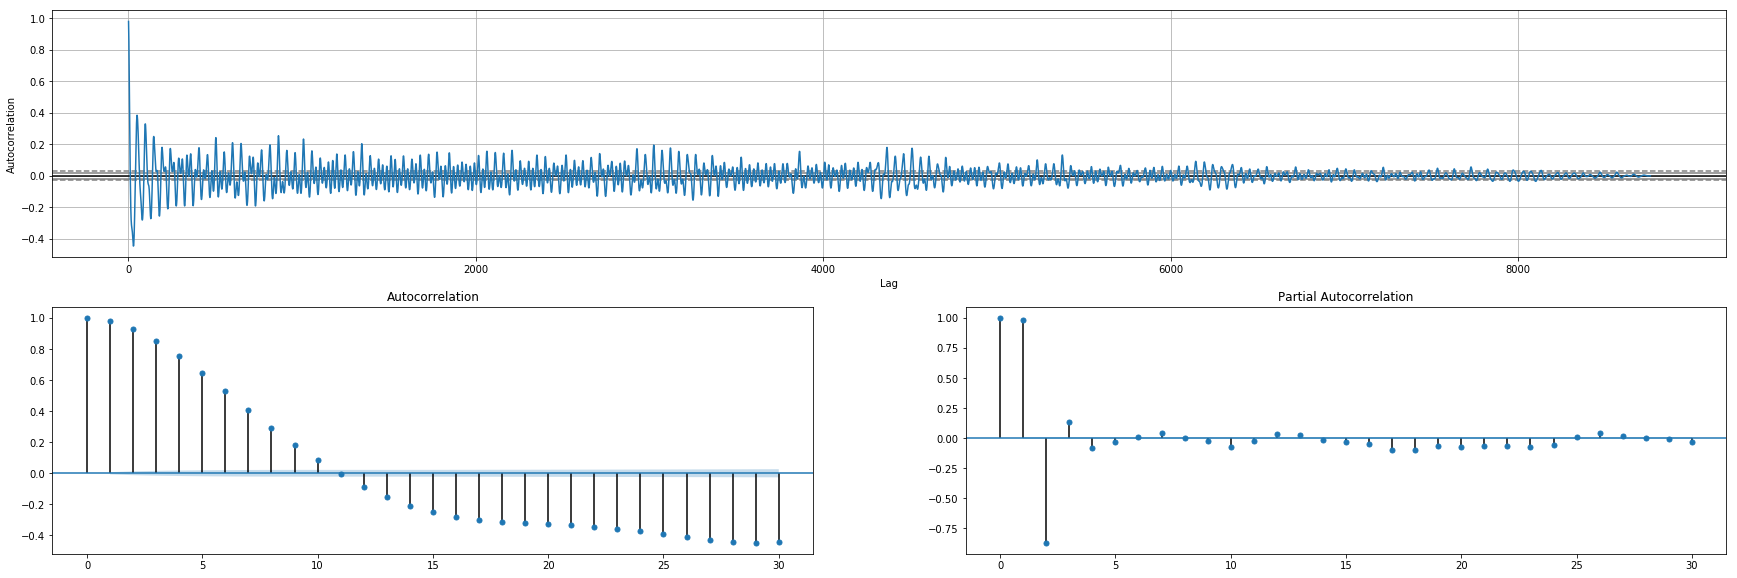

In [ ]:
for column in data1:
    if column not in ['DATETIME', 'ATT_FLAG']:
        fig = plt.figure(figsize=(30, 10))
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        autocorrelation_plot(data1[column], ax=ts_ax)
        smt.graphics.plot_acf(data1[column], lags=30, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(data1[column], lags=30, ax=pacf_ax, alpha=0.5)

#### ARMA

To estimate the ARMA order values we did a grid search on each sensors data, the best model is chosen based on the lowest value for Akaike’s Information Criterion (AIC).

#### Find best ARMA order

In [ ]:
import statsmodels.api as sm

minimum_orders = {}
for column in data1:
    if column not in ['DATETIME', 'ATT_FLAG']:
        res = sm.tsa.arma_order_select_ic(data1[column], max_ar=5, max_ma=5, model_kw={'freq': 'H'}, fit_kw={'method': 'mle'}, ic=['aic'], trend='nc')
        minimum_orders[column] = res.aic_min_order
        print(minimum_orders)

#### Test how well each signal predicts

To quantify how well the different values predict run on the the first $5000$ sensor readings of dataset 1 and calculating an MSE error between the actual and predicted values for $50$ successive values. 

L_T1 1.4569089571257323
L_T2 2.1707342190315617
L_T3 0.10070578571689456


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


L_T4 0.363485078956721
L_T5 0.6353612714073456
L_T6 0.029668846680840494
L_T7 0.3963293362688157
F_PU1 68.77441145980663


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


S_PU1 0.0
Error on F_PU2, The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
Error on S_PU2, The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/ar_model.py:765: RuntimeWarning: divide by zero encountered in log
  return np.log(self.sigma2) + (1 + self.df_model) * np.log(nobs)/nobs


Error on F_PU3, SVD did not converge
Error on S_PU3, SVD did not converge
F_PU4 106.34742286135369


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


S_PU4 0.08865767475234607
Error on F_PU5, SVD did not converge
Error on S_PU5, SVD did not converge
Error on F_PU6, The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
Error on S_PU6, The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
F_PU7 362.38380262624145
S_PU7 0.14809121148173662
F_PU8 348.9089432171197
S_PU8 0.30666846365992195
Error on F_PU9, SVD did not converge
Error on S_PU9, SVD did not converge
F_PU10 153.67462933779876
S_PU10 0.16138051784251506
F_PU11 0.00031721779927367086


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


S_PU11 6.403535784628126e-07
F_V2 1277.4103278159164
S_V2 0.1994538735729069


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


P_J280 4.058497974544293e-05
P_J269 21.016568199760055


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


P_J300 6.971448955157874
P_J256 46.544045934222055


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


Error on P_J289, SVD did not converge
P_J415 67.6667857433073
P_J302 23.582426925318345
P_J306 112.38164429047829
P_J307 23.752906406710427
P_J317 28.50947458230003
P_J14 21.090393114764584
P_J422 7.042291916997987
{'L_T1': 1.4569089571257323, 'L_T2': 2.1707342190315617, 'L_T3': 0.10070578571689456, 'L_T4': 0.363485078956721, 'L_T5': 0.6353612714073456, 'L_T6': 0.029668846680840494, 'L_T7': 0.3963293362688157, 'F_PU1': 68.77441145980663, 'S_PU1': 0.0, 'F_PU4': 106.34742286135369, 'S_PU4': 0.08865767475234607, 'F_PU7': 362.38380262624145, 'S_PU7': 0.14809121148173662, 'F_PU8': 348.9089432171197, 'S_PU8': 0.30666846365992195, 'F_PU10': 153.67462933779876, 'S_PU10': 0.16138051784251506, 'F_PU11': 0.00031721779927367086, 'S_PU11': 6.403535784628126e-07, 'F_V2': 1277.4103278159164, 'S_V2': 0.1994538735729069, 'P_J280': 4.058497974544293e-05, 'P_J269': 21.016568199760055, 'P_J300': 6.971448955157874, 'P_J256': 46.544045934222055, 'P_J415': 67.6667857433073, 'P_J302': 23.582426925318345, 'P_J

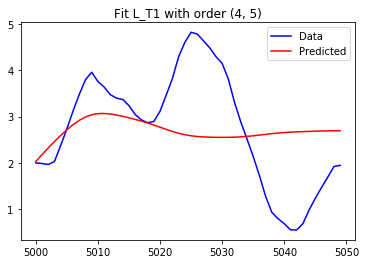

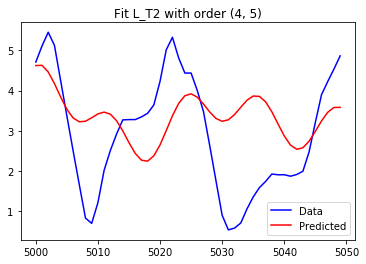

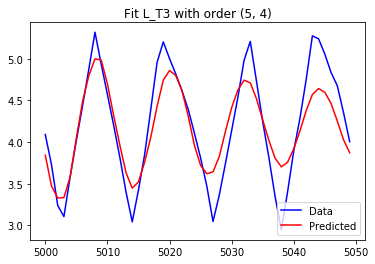

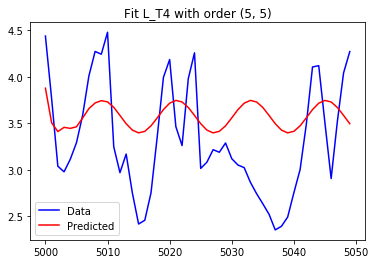

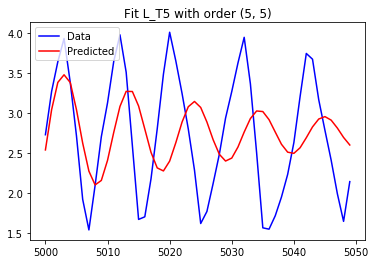

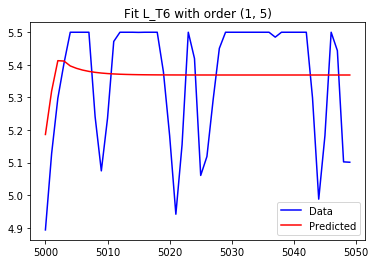

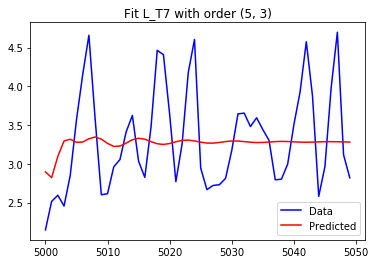

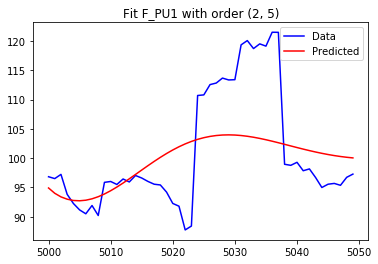

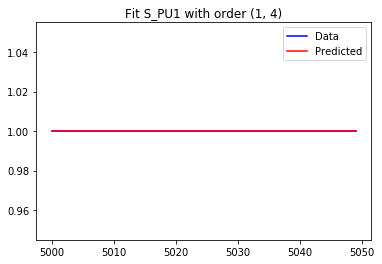

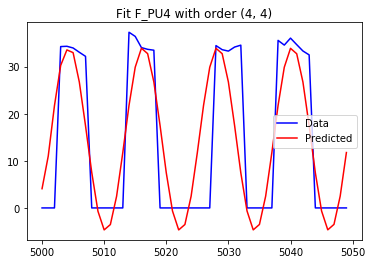

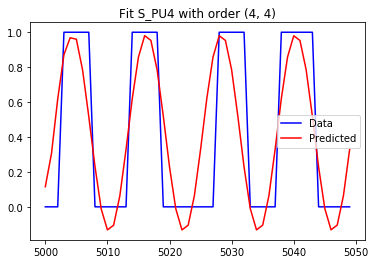

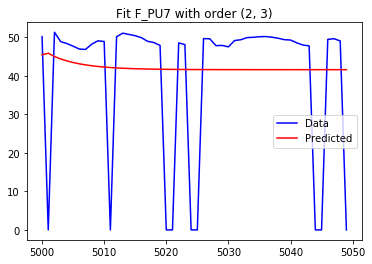

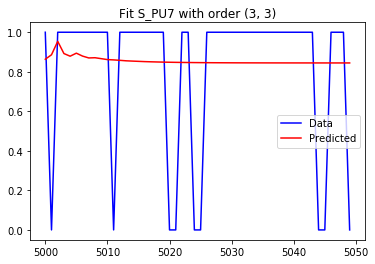

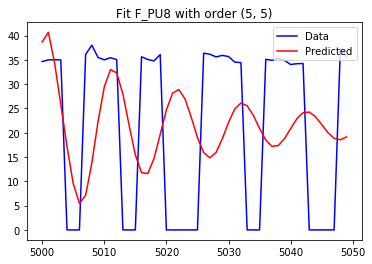

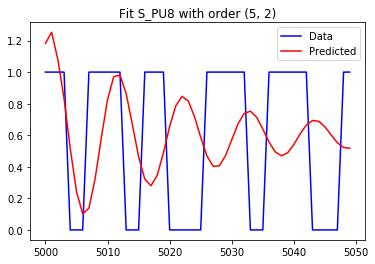

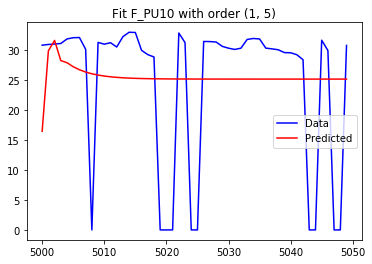

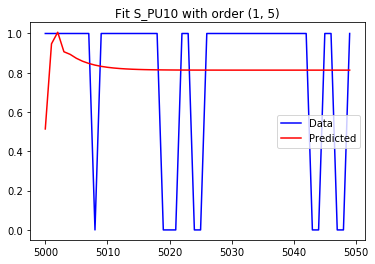

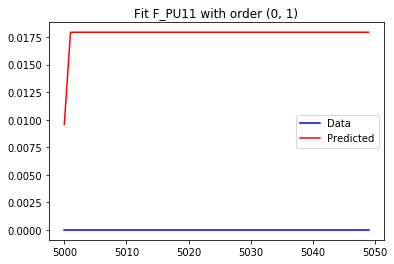

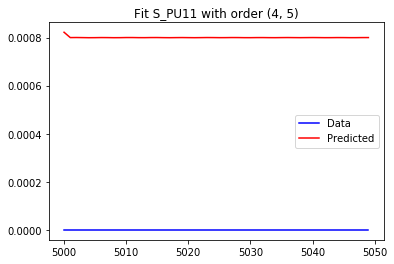

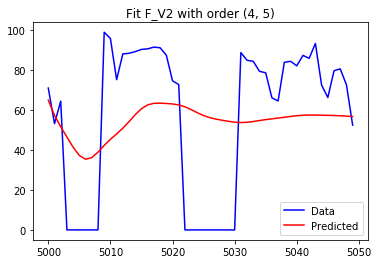

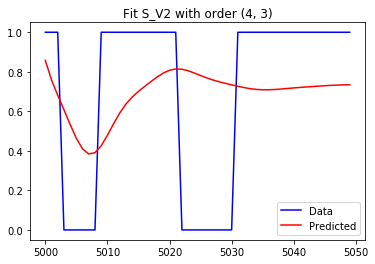

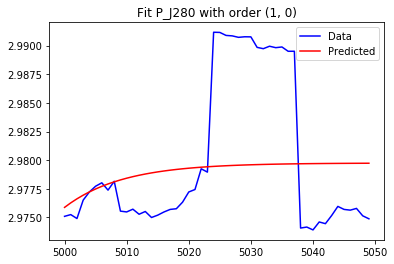

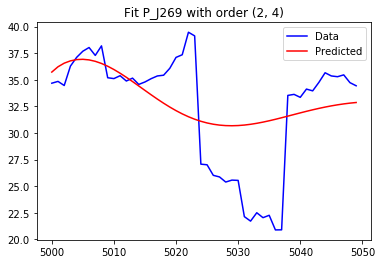

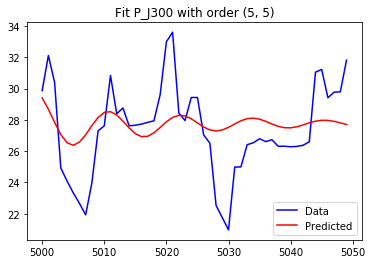

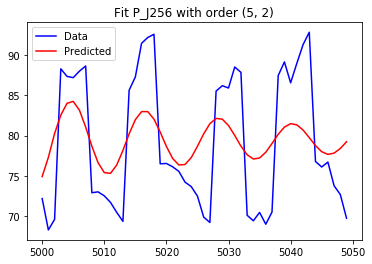

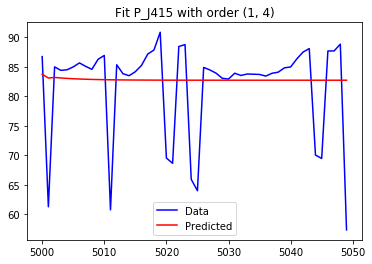

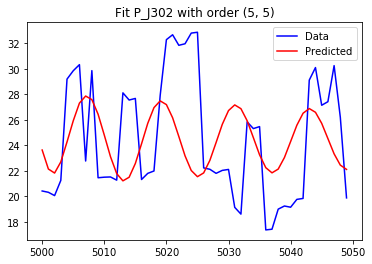

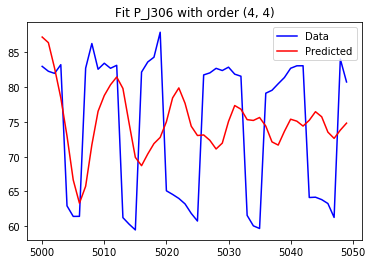

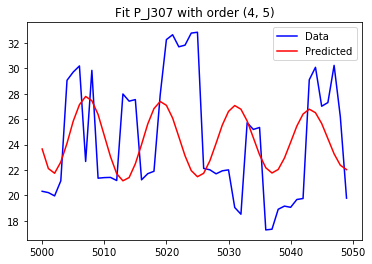

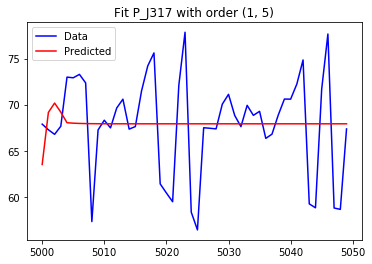

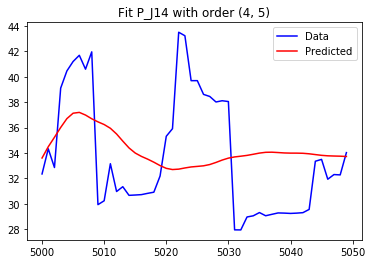

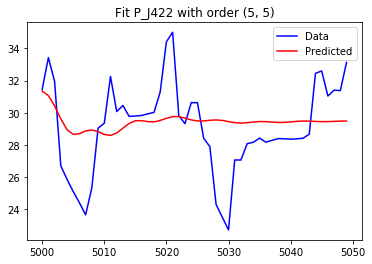

In [7]:
# Cache here from previous cell
pqdict= {'L_T1': (4, 5), 'L_T2': (4, 5), 'L_T3': (5, 4), 'L_T4': (5, 5), 'L_T5': (5, 5), 'L_T6': (1, 5), 'L_T7': (5, 3), 'F_PU1': (2, 5), 'S_PU1': (1, 4), 'F_PU2': (5, 4), 'S_PU2': (5, 5), 'F_PU3': (1, 1), 'S_PU3': (1, 1), 'F_PU4': (4, 4), 'S_PU4': (4, 4), 'F_PU5': (1, 1), 'S_PU5': (1, 1), 'F_PU6': (0, 2), 'S_PU6': (0, 2), 'F_PU7': (2, 3), 'S_PU7': (3, 3), 'F_PU8': (5, 5), 'S_PU8': (5, 2), 'F_PU9': (1, 1), 'S_PU9': (1, 1), 'F_PU10': (1, 5), 'S_PU10': (1, 5), 'F_PU11': (0, 1), 'S_PU11': (4, 5), 'F_V2': (4, 5), 'S_V2': (4, 3), 'P_J280': (1, 0), 'P_J269': (2, 4), 'P_J300': (5, 5), 'P_J256': (5, 2),
'P_J289': (5, 4), 'P_J415': (1, 4), 'P_J302': (5, 5), 'P_J306': (4, 4), 'P_J307': (4, 5), 'P_J317': (1, 5), 'P_J14': (4, 5), 'P_J422': (5, 5)}

# Calculate all MSE
all_mse = {}
for column in data1:
    if column not in ['DATETIME', 'ATT_FLAG']:
        try:
            train = data1[column][:5000]
            test = data1[column][5000:5050]

            # Fit again so we can use predict function ARMA
            model = ARMA(train, order=pqdict[column], freq='H').fit(method='mle')
            
            x = (5000, 5050)
            predict = model.predict(*x)

            y = []
            y_hat = []
            for y_predicted, y_test in zip(predict, test):
                y.append(y_test)
                y_hat.append(y_predicted)

            mse = mean_squared_error(y, y_hat)
            print(column, str(mse))
            all_mse[column] = mse

            fig, ax = plt.subplots()
            ax.plot(list(range(*x)), y, color='b', label='Data')
            ax.plot(list(range(*x)), y_hat, color='r', label='Predicted')
            ax.set_title('Fit {} with order {}'.format(column, str(pqdict[column])))
            ax.legend(loc='best')
        except Exception as e:
            print('Error on {}, {}'.format(column, str(e)))

print(all_mse)

#### Fit ARMA model based on order from previously found order (DO NOT RUN IF YOU IF WANT TO USE PROVIDED PRE-FIT MODEL)

In [ ]:
# Cache from a previous cell
pqdict= {'L_T1': (4, 5), 'L_T2': (4, 5), 'L_T3': (5, 4), 'L_T4': (5, 5), 'L_T5': (5, 5), 'L_T6': (1, 5), 'L_T7': (5, 3), 'F_PU1': (2, 5), 'S_PU1': (1, 4), 'F_PU2': (5, 4), 'S_PU2': (5, 5), 'F_PU3': (1, 1), 'S_PU3': (1, 1), 'F_PU4': (4, 4), 'S_PU4': (4, 4), 'F_PU5': (1, 1), 'S_PU5': (1, 1), 'F_PU6': (0, 2), 'S_PU6': (0, 2), 'F_PU7': (2, 3), 'S_PU7': (3, 3), 'F_PU8': (5, 5), 'S_PU8': (5, 2), 'F_PU9': (1, 1), 'S_PU9': (1, 1), 'F_PU10': (1, 5), 'S_PU10': (1, 5), 'F_PU11': (0, 1), 'S_PU11': (4, 5), 'F_V2': (4, 5), 'S_V2': (4, 3), 'P_J280': (1, 0), 'P_J269': (2, 4), 'P_J300': (5, 5), 'P_J256': (5, 2),
'P_J289': (5, 4), 'P_J415': (1, 4), 'P_J302': (5, 5), 'P_J306': (4, 4), 'P_J307': (4, 5), 'P_J317': (1, 5), 'P_J14': (4, 5), 'P_J422': (5, 5)}

def fit_arma_on_training_data():
    models = {}
    for idx, column in enumerate(data1):
        try:
            model = ARMA(data1[column], order=pqdict[column], freq='H').fit(method='mle')
        except Exception as e:
            print('Failed {}'.format(str(e)))
        else:
            models[column] = {
                'arparams': model.arparams,
                'maparams': model.maparams,
                'resid': model.resid
            }
            
        print('Completed {}'.format(idx / len(pqdict)))
    return models

print('Saving to file.')

trained_models = fit_arma_on_training_data()
with open('trained_models.pickle', 'wb') as handle:
    pickle.dump(trained_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Models saved to file.')

#### Test the fitted ARMA models on data2 and test data

Trained models for: dict_keys(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'S_PU2', 'F_PU4', 'S_PU4', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J307', 'P_J317', 'P_J14'])
Saved ARMA orders for: dict_keys(['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422'])
warning_L_T1
warning_L_T3
warning_L_T5
warning_F_PU1
warning_F_PU7
warning_F_PU10
warning_S_PU10
warning_F_PU11
warning_S_V2
warning_P_J256
warning_P_J415
warning_P_J302
warning_P_J307
warning_P_J317
warning_P_J14
Confusion matrix, without normaliz

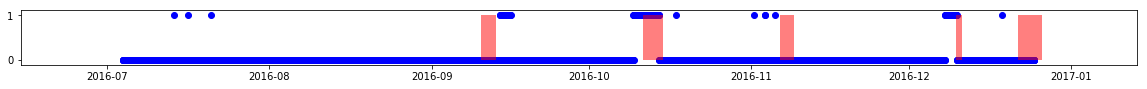

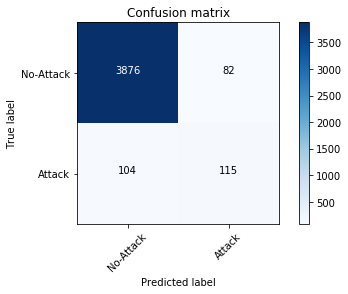

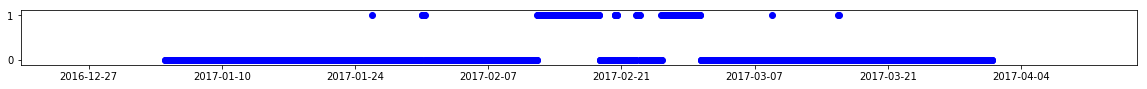

In [48]:
def predict(coef, history, mode='ar'):
    """
    based on: https://machinelearningmastery.com/make-manual-predictions-arima-models-python/
    """
    if mode == 'ar':
        m = 1
    elif mode == 'ma':
        m = 0
    
    yhat = 0.0
    for i in range(1, len(coef) + 1):
        yhat += coef[i-1] * history[-i]
    return yhat

def difference(history):
    """
    based on: https://machinelearningmastery.com/make-manual-predictions-arima-models-python/
    """
    diff = list()
    for i in range(1, len(history)):
        value = history[i] - history[i - 1]
        diff.append(value)
    return np.array(diff)

# Cache from a previous cell
pqdict= {'L_T1': (4, 5), 'L_T2': (4, 5), 'L_T3': (5, 4), 'L_T4': (5, 5), 'L_T5': (5, 5), 'L_T6': (1, 5), 'L_T7': (5, 3), 'F_PU1': (2, 5), 'S_PU1': (1, 4), 'F_PU2': (5, 4), 'S_PU2': (5, 5), 'F_PU3': (1, 1), 'S_PU3': (1, 1), 'F_PU4': (4, 4), 'S_PU4': (4, 4), 'F_PU5': (1, 1), 'S_PU5': (1, 1), 'F_PU6': (0, 2), 'S_PU6': (0, 2), 'F_PU7': (2, 3), 'S_PU7': (3, 3), 'F_PU8': (5, 5), 'S_PU8': (5, 2), 'F_PU9': (1, 1), 'S_PU9': (1, 1), 'F_PU10': (1, 5), 'S_PU10': (1, 5), 'F_PU11': (0, 1), 'S_PU11': (4, 5), 'F_V2': (4, 5), 'S_V2': (4, 3), 'P_J280': (1, 0), 'P_J269': (2, 4), 'P_J300': (5, 5), 'P_J256': (5, 2),
'P_J289': (5, 4), 'P_J415': (1, 4), 'P_J302': (5, 5), 'P_J306': (4, 4), 'P_J307': (4, 5), 'P_J317': (1, 5), 'P_J14': (4, 5), 'P_J422': (5, 5)}


def run_all_test_arma(dataset_name, create_temp_plots=False):
    
    if dataset_name == 'data2':  
        run_on_data = data2.copy()
    elif dataset_name == 'test':
        run_on_data = test_set.copy()

    # Open cached trained model from previous cell (this file is provided)
    with open('trained_models.pickle', 'rb') as handle:
        saved_trained_models = pickle.load(handle)
        print('Trained models for: {}'.format(saved_trained_models.keys()))
        print('Saved ARMA orders for: {}'.format(pqdict.keys()))

        # Run over all columns
        for column_name, column_params in saved_trained_models.items():
            try:
                last_known_idx = max(pqdict[column_name]) + 1
                residuals = [0] * max(pqdict[column_name])
                
                # Where all predictions are stored for this column, first few (size of order) are 
                # filled with real data
                predictions = run_on_data[column_name][:max(pqdict[column_name]) + 1].values.tolist()
                
                while last_known_idx < len(run_on_data):
                    
                    # Keep track of history for AR
                    history = run_on_data[column_name][last_known_idx - pqdict[column_name][0] - 1:last_known_idx]
                    
                    # Predict using coefficients
                    yhat = np.mean(data1[column_name]) + \
                           predict(column_params['arparams'], difference(history), mode='ar') + \
                           predict(column_params['maparams'], residuals, mode='ma')
                    
                    # Add new residuals
                    if last_known_idx < len(run_on_data) - 1:
                        residuals.append(run_on_data[column_name][last_known_idx + 1] - yhat)

                    predictions.append(yhat)
                    last_known_idx += 1

                # Add an extra column prefixed with 'predicted' with the predicted values for each date
                run_on_data['predicted_{}'.format(column_name)] = predictions

                last_predicted = run_on_data['predicted_{}'.format(column_name)]
                last_data = run_on_data[column_name]
                if create_temp_plots:
                    # Create plots for individual columns
                    fig, ax = plt.subplots(figsize=(20, 6))
                    ax.plot(run_on_data.index.values, last_predicted, 'g-', label='predicted')
                    ax.plot(run_on_data.index.values, last_data, 'b-', label='real')
                    
                    if dataset_name == 'data2':
                        test_attacks = get_relative_attack_data(run_on_data, 0.002)
                        for att in test_attacks:
                            ax.axhspan(ymin=min(min(last_predicted), min(last_data)), 
                                       ymax=max(max(last_predicted), max(last_data)), 
                                       xmin=att[0], 
                                       xmax=att[1], 
                                       facecolor='r', 
                                       alpha=0.5)
                        ax.legend(loc='best')
                        
                    ax.set_title(column_name)

            except Exception as e:
                print('Exception {}, {}'.format(column_name, e))



        ###
        # Start data aggregation of all columns and anomaly detection based on threshold
        ###
        
        # Get baseline from trainingset
        stds_per_column = np.std(data1)

        good_fit_columns = ['L_T1', 'L_T3', 'L_T5', 'F_PU1', 'SPU2', 'F_PU11', 'F_PU7', 'SPU7', 'F_PU10', 'S_PU10', 
                            'F_PU11' 'P_J269', 'P_J14', 'S_V2', 'P_J256', 'P_J415', 'P_J302', 'P_J307', 'P_J317', 'P_J14']

        # Add a new column for each well fit column that saves a 1 when data is anomaly
        for column in run_on_data:
            if 'predicted_' in column and column.replace('predicted_', '') in good_fit_columns:
                threshold = stds_per_column[column.replace('predicted_', '')] * 28
                warning_column_name = 'warning_{}'.format(column.replace('predicted_', ''))
                warnings = []
                for idx, point in run_on_data[column].items():
                    if point > threshold:
                        warnings.append(1)
        #                 print('Warning raised by {} on {}, with value {} over {}'.format(column, idx, point, threshold))
                    else:
                        warnings.append(0)
                run_on_data[warning_column_name] = warnings

        # Merge all warning columns to get one column that we can plot
        all_warnings = [0] * len(run_on_data)
        for column in run_on_data:
            if 'warning_' in column and column.replace('warning_', '') in good_fit_columns:
                print(column)
                for idx, row in enumerate(run_on_data[column]):
                    if row == 1:
                        all_warnings[idx] = 1

        # Make the final warnings plot
        fig, ax = plt.subplots(figsize=(20, 1))
        ax.scatter(run_on_data.index.values, all_warnings, c='b', label='real')
        
        if dataset_name == 'data2':
            test_attacks = get_relative_attack_data(run_on_data, 0.002)
            for att in test_attacks:
                ax.axhspan(ymin=0, 
                           ymax=1, 
                           xmin=att[0], 
                           xmax=att[1], 
                           facecolor='r', 
                           alpha=0.5)
            
            # Confusion matrix
            binary_conf_pred = [True if x == 1 else False for x in all_warnings]
            cnf_matrix = confusion_matrix(binary_conf_value, binary_conf_pred)
            plt.figure()
            plot_confusion_matrix(cnf_matrix, ['No-Attack', 'Attack'])
                
run_all_test_arma('data2')
run_all_test_arma('test')

## Discrete models task - 1/2 A4
Discretize the sensor data using any of the methods discussed in class. Explain why you choose 
this method and why the obtained discretization makes sense. Visualize the discretization.
Apply any of the sequential data mining methods (N-grams, Sequence alignment with kNN, ...) to 
sliding windows with a length of your choosing in order to find anomalies. Whenever an 
observed N-gram’s probability is too small, or the sequential data is too distant from any training 
sequence, raise an alarm. Set your thresholds sensibly. 

What kind of anomalies can you detect using the sequential model? Which sensors can be modeled effectively?

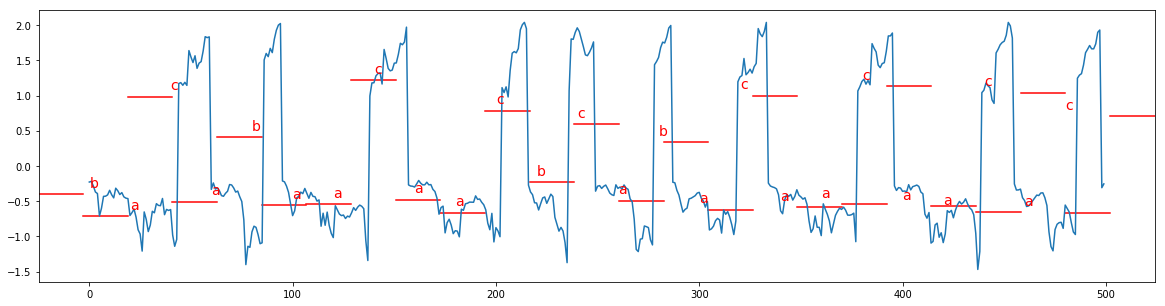

In [38]:
# 2. Visualize discretization (Seperate from rest)

from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

def visualize_discretize(data_list, letters=5, chunk_size=3, title=''):
    
    # Chunks of size "chunk_size"
    chunks = int(len(data_list) / chunk_size)

    d_znorm = znorm(data_list.values)
    d_paa = paa(d_znorm, chunks)
    categories = ts_to_string(d_paa, cuts_for_asize(letters))

    split_size = len(d_znorm) / len(d_paa)
    offset = 0
    next_offset = split_size
    
    plt.figure(figsize=(20,5))
    for p, cat in zip(d_paa, categories):
        xmin = offset / len(d_znorm)
        xmax = next_offset / len(d_znorm)
        plt.axhline(y=p, xmin=xmin, xmax=xmax, color='r')
        plt.text(offset, p + 0.1, cat, color='r', fontsize=14)
        
        offset += split_size
        next_offset += split_size
        
    plt.plot(d_znorm)
    
    if title:
        plt.title(title)
    
    plt.show()

    window_size = 100

visualize_discretize(data1['F_PU1'][:500], letters=3, chunk_size=20)

#### Ngram

In [39]:
# 3. Apply sequential data mining methods (N-grams, Sequence alignment with kNN, ...) to 
#    sliding windows with a length of your choosing in order to find anomalies

# compute the probability of observing a sequence


from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

from itertools import permutations
from itertools import islice
from collections import Counter

def znorm_custom(series, znorm_threshold=0.01):
    """
    Custom implementation of SAX znorm, because we need it to return the mean and sd from the training set
    
    https://github.com/seninp/saxpy/blob/master/saxpy/znorm.py
    """
    sd = np.std(series)
    if (sd < znorm_threshold):
        return series
    mean = np.mean(series)
    
    return ((series - mean) / sd), mean, sd


def window(seq, n=2):
    """
    Returns a sliding window (of width n) over data from the iterable
     s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...   
    
    https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator
    """            
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

        
def create_ngrams_probs(data_list, ngram_size=3, chunk_size=3, letters=5):
    chunks = int(len(data_list) / chunk_size)
    
    d_znorm, mean, sd = znorm_custom(data_list)
    d_paa = paa(d_znorm, chunks)
    categories = ts_to_string(d_znorm, cuts_for_asize(letters))
        
    ngrams = list(window(categories, n=ngram_size))
    ngram_count = Counter(ngrams)
    ngram_count_minus_1 = Counter([x[:-1] for x in ngrams])
    
#     print(ngram_count)
#     print(ngram_count_minus_1)
    
    probs = {}
    for gram, count in ngram_count.items():
        probs[gram] = count / ngram_count_minus_1[gram[:-1]]
    
    return probs, mean, sd

def test_data_ngram(test_data_list, train_probs_threshold, train_mean, train_sd, rolling_window_size=20, letters=5, chunk_size=3):
    """
    Generator that loops over all rolling windows and yields the probabilities for the current window
    """
    
    chunks = int(len(test_data_list) / chunk_size)
    
    all_probs_window = {}
    
    # Get n-gram size from training data
    ngram_size = len(next(iter(train_probs_threshold)))
    
    d_znorm = (test_data_list - train_mean) / train_sd
    d_paa = paa(d_znorm, chunks)
    categories = ts_to_string(d_znorm, cuts_for_asize(letters))

    ngram_list = []
    ngram_list_minus_1 = []
    for new_ngram in window(categories, n=ngram_size): # Loops over n-rams in window       
        ngram_list.append(new_ngram)
        ngram_list_minus_1.append(new_ngram[:-1])
        
        if len(ngram_list) > rolling_window_size:
            # Once rolling window reached its max size, forget the oldest value
            del ngram_list[0]
            del ngram_list_minus_1[0]

        # Create ngram counts
        ngram_count = Counter(ngram_list)
        ngram_count_minus_1 = Counter(ngram_list_minus_1)

        # Calculate all probabilities again
        for k, v in ngram_count.items():
            prob = ngram_count[k] / ngram_count_minus_1[k[:-1]]
            all_probs_window[k] = prob
        
        yield all_probs_window


train_probs, train_mean, train_sd = create_ngrams_probs(data1['L_T1'][:50])
print(train_probs)

{('a', 'a', 'a'): 0.8333333333333334, ('a', 'a', 'b'): 0.16666666666666666, ('a', 'b', 'b'): 1.0, ('b', 'b', 'b'): 0.7142857142857143, ('b', 'b', 'a'): 0.14285714285714285, ('b', 'a', 'a'): 1.0, ('b', 'b', 'c'): 0.14285714285714285, ('b', 'c', 'c'): 1.0, ('c', 'c', 'c'): 0.5, ('c', 'c', 'd'): 0.5, ('c', 'd', 'd'): 1.0, ('d', 'd', 'd'): 0.7142857142857143, ('d', 'd', 'e'): 0.2857142857142857, ('d', 'e', 'e'): 1.0, ('e', 'e', 'e'): 0.9166666666666666, ('e', 'e', 'd'): 0.08333333333333333, ('e', 'd', 'd'): 1.0}


#### Run $N$-gram on data2 / test set

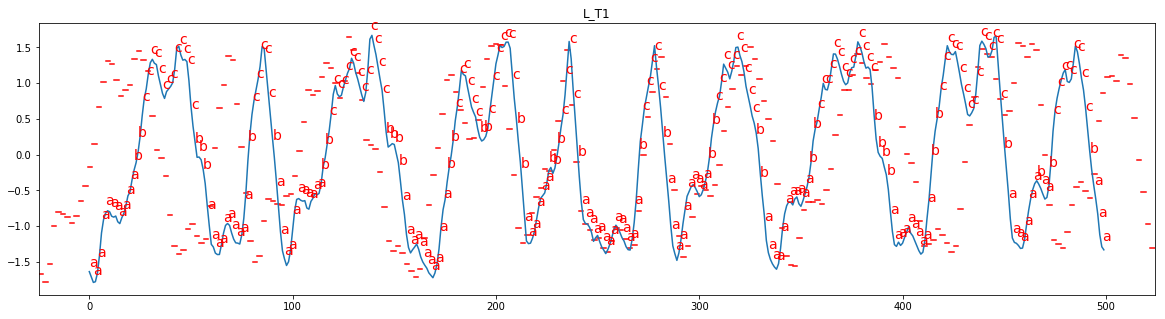

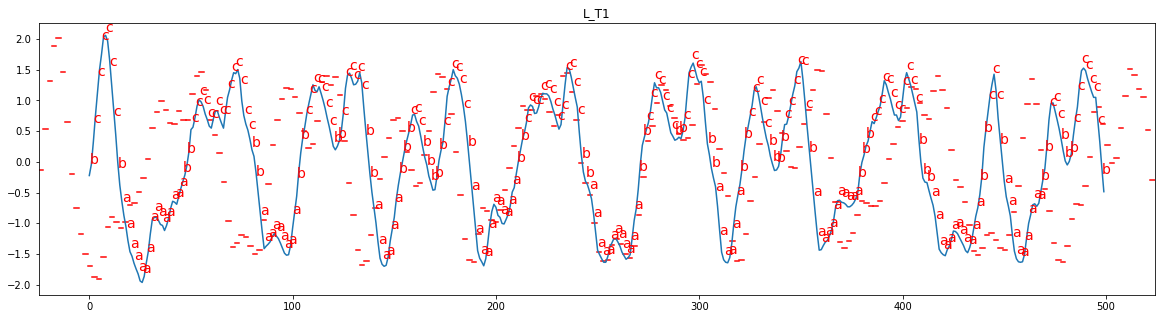

KeyboardInterrupt: 

In [106]:
# columns_to_test = ['F_PU1', 'F_PU11']
columns_to_test = ['P_J14', 'F_PU1', 'F_PU2', 'F_PU3', 'S_PU4', 'F_PU7', 'S_PU7', 'F_PU10', 'S_PU10', 'L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T6', 'L_T7', 'P_J422', 'P_J14']

# BEGIN PARAMETERS
cp = {
    'F_PU1': { # Correct
        'n_gramsize': 5,
        'letters': 3,
        'chunk_size': 20
    },
    'F_PU2': { # Correct
        'n_gramsize': 5,
        'letters': 2,
        'chunk_size': 20
    },
    'S_PU2': { # Correct
        'n_gramsize': 5,
        'letters': 2,
        'chunk_size': 20
    },
    'F_PU3': { #Correct
        'n_gramsize': 5,
        'letters': 3,
        'chunk_size': 5
    },
     'S_PU4': { #Correct
        'n_gramsize': 7,
        'letters': 3,
        'chunk_size': 2
    },
    'F_PU7': { #Correct
        'n_gramsize': 5,
        'letters': 3,
        'chunk_size': 2
    },
    'S_PU7': { #Correct
        'n_gramsize': 5,
        'letters': 2,
        'chunk_size': 5
    },
    'F_PU10': { #Correct
        'n_gramsize': 5,
        'letters': 2,
        'chunk_size': 5
    },
    'S_PU10': { #Correct
        'n_gramsize': 6,
        'letters': 3,
        'chunk_size': 6
    },
    'L_T1': { #Correct
        'n_gramsize': 10,
        'letters': 3,
        'chunk_size': 2
    },
    'L_T2': { #Correct
        'n_gramsize': 4,
        'letters': 3,
        'chunk_size': 5
    },
    'L_T3': { #Correct
        'n_gramsize': 5,
        'letters': 3,
        'chunk_size': 5
    },
    'L_T4': { #Correct
        'n_gramsize': 5,
        'letters': 3,
        'chunk_size': 5
    },
     'L_T6': { #Correct
        'n_gramsize': 5,
        'letters': 2,
        'chunk_size': 5
    },
      'P_J422': { #Correct
        'n_gramsize': 4,
        'letters': 2,
        'chunk_size': 5
    },
       'P_J14': { #Correct
        'n_gramsize': 5,
        'letters': 2,
        'chunk_size': 5
    },
     'L_T7': { #Correct
        'n_gramsize': 2,
        'letters': 2,
        'chunk_size': 2
    } 
}
window_size = 100
training_size = 500
extra_c = .05
# END PARAMTERS


def evaluate_probs(window_probs_dict, training_probs_dict):
    """
    Compare all probs in the window with training data
    """
    for ngram, prob in window_probs_dict.items():
        if prob > training_probs_dict.get(ngram, 0) + extra_c: # If cannot be found in training return 0
            return 1
        else:
            return 0

def test_all_ngram(dataset_name):
    
    ngram_train_set = data1.copy()

    if dataset_name == 'data2':
        ngram_test_set_to_run = data2.copy()
    elif dataset_name == 'test':
        ngram_test_set_to_run = test_set.copy()
    
    for column in ngram_test_set_to_run:
        if column in columns_to_test:

            # Load column specific parameters
            n_gramsize = cp[column]['n_gramsize']
            letters = cp[column]['letters']
            chunk_size = cp[column]['chunk_size']

            # Visualize column
            visualize_discretize(ngram_train_set[column][:500], letters=letters, chunk_size=chunk_size, title=column)
            visualize_discretize(ngram_test_set_to_run[column][:500], letters=letters, chunk_size=chunk_size, title=column)

            # Create N-grams from training set with specified parameters for column
            train_probs, train_mean, train_sd = create_ngrams_probs(ngram_train_set[column][:training_size], 
                                                                    ngram_size=n_gramsize, chunk_size=chunk_size, 
                                                                    letters=letters)
            # Add new column to store probable anomalies
            warning_column_name = 'warning_{}'.format(column)
            warnings = [0] * (n_gramsize - 1)
            for idx, pred_probs in enumerate(test_data_ngram(ngram_test_set_to_run[column], train_probs, train_mean, train_sd,
                                             rolling_window_size=window_size, letters=letters, chunk_size=chunk_size)):

                # Start evalutating once window is full
                if idx > window_size:
                    warnings.append(evaluate_probs(pred_probs, train_probs))
                else:
                    warnings.append(0)

            # Add stored warnings/anomalies to dataframe
            ngram_test_set_to_run[warning_column_name] = warnings

    # Merge all warning columns to get one column that we can plot
    all_warnings = [0] * len(ngram_test_set_to_run)
    for column in ngram_test_set_to_run:
        if 'warning_' in column:
            for idx, row in enumerate(ngram_test_set_to_run[column]):
                if row == 1:
                    all_warnings[idx] = 1

    # Make the final warnings plot
    fig, ax = plt.subplots(figsize=(20, 2))
    ax.scatter(ngram_test_set_to_run.index.values, all_warnings, c='b', label='real')
    
    if dataset_name == 'data2':
        test_attacks = get_relative_attack_data(ngram_test_set_to_run, 0.002)
        for att in test_attacks:
            ax.axhspan(ymin=0, 
                       ymax=1, 
                       xmin=att[0], 
                       xmax=att[1], 
                       facecolor='r', 
                       alpha=0.5)
        
        # Confusion matrix
        binary_conf_pred = [True if x == 1 else False for x in warnings]
        cnf_matrix = confusion_matrix(binary_conf_value, binary_conf_pred)
        plt.figure()
        plot_confusion_matrix(cnf_matrix, ['No-Attack', 'Attack'])

test_all_ngram('data2')
# test_all_ngram('test')

## PCA task – 1/2 A4 
Perform PCA-based anomaly detection on the signal data. Set the threshold on training data to a 
value that results in few false positives on the training data. Plot the PCA residuals in one signal. 
Do you see large abnormalities in the training data? Can you explain why these occur? It is best to
remove such abnormalities from the training data since you only want to model normal behavior. 
What kind of anomalies can you detect using PCA?

Eigenvectors shape: (43, 13)
X shape: (4177, 44)
Q shape: (43, 43)
y curlies shape: (43, 4177)
Confusion matrix, without normalization
[[3937   21]
 [ 210    9]]
Eigenvectors shape: (43, 13)
X shape: (2089, 43)
Q shape: (43, 43)
y curlies shape: (43, 2089)


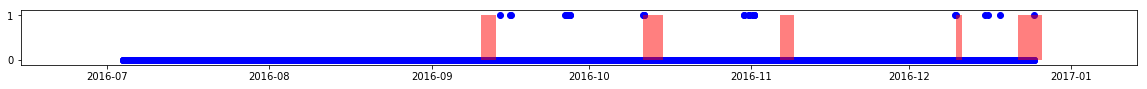

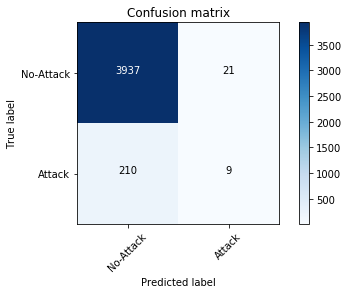

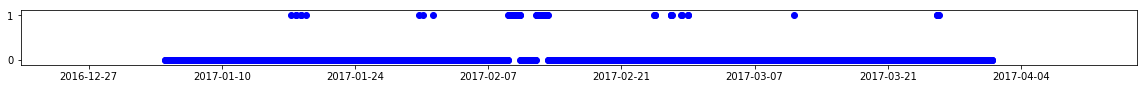

In [47]:
from sklearn.decomposition import PCA


def test_pca(dataset_name):
    pca_set_to_train = data1.copy()
    pca_set_to_train.drop(columns=['ATT_FLAG'], inplace=True)

    if dataset_name == 'data2':
        pca_set_to_run = data2.copy()
        pca_without_attack_to_run = pca_set_to_run.drop(columns=['ATT_FLAG'])
        test_attacks = get_relative_attack_data(pca_set_to_run, 0.002)
    elif dataset_name == 'test':
        pca_set_to_run = test_set.copy()
        pca_without_attack_to_run = pca_set_to_run

    # BEGIN PARAMETERS
    n_components = 13
    threshold = 2.9
    # END PARAMETERS

    scaler = StandardScaler()
    pca = decomposition.PCA()
    pca_model = pca.fit_transform(scaler.fit_transform(pca_set_to_train))

    P = pca.components_[:n_components].T
    print('Eigenvectors shape: ' + str(P.shape))
    print('X shape: ' + str(pca_set_to_run.shape))

    Q = (np.identity(43) - (P @ P.T))
    print('Q shape: ' + str(Q.shape))
    y_curlies = Q @ scaler.fit_transform(pca_without_attack_to_run).T

    print('y curlies shape: ' + str(y_curlies.shape))

    def spe(y_curly):
        return np.sqrt(np.sum(np.square(y_curly)))

    warnings = []
    for y_curly in y_curlies.T:
        if spe(y_curly) <= threshold:
            warnings.append(0)
        else:
            warnings.append(1)

    # Make the final warnings plot
    fig, ax = plt.subplots(figsize=(20, 1))
    ax.scatter(pca_set_to_run.index.values, warnings, c='b', label='real')
    
    if dataset_name == 'data2':
        for att in test_attacks:
            ax.axhspan(ymin=0, 
                       ymax=1, 
                       xmin=att[0], 
                       xmax=att[1], 
                       facecolor='r', 
                       alpha=0.5)
        
        # Confusion matrix    
        binary_conf_pred = [True if x == 1 else False for x in warnings]
        cnf_matrix = confusion_matrix(binary_conf_value, binary_conf_pred)
        plt.figure()
        plot_confusion_matrix(cnf_matrix, ['No-Attack', 'Attack'])

test_pca('data2')
test_pca('test')